In [103]:
# Type annotations :
from typing import Tuple, List, Optional, NoReturn, Callable, Any


# Standard and OS :
import copy
import json
import glob
import os
import importlib # Required to reload a module
                 # because the Jupyter Kernel
                 # won't  really reimport by itself.
import multiprocessing as mp

# Image processing :
import skimage
import cv2 as cv

# Numeric :
import numpy as np
import pandas as pd

# Visualisation :
import matplotlib.pyplot as plt
import seaborn as sns

# Machine-Learning :
from sklearn.cluster import KMeans

# Functional programing tools : 
from functools import partial, reduce
from itertools import chain


In [2]:
import mfilt_funcs as mfs
importlib.reload(mfs)
import mfilt_funcs as mfs

import utils
importlib.reload(utils)
import utils

In [3]:
lmap = lambda x, y: list(map(x, y))
lfilter = lambda x, y: list(filter(x, y))
imread = lambda x: cv.imread(x, 0)

In [4]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (12, 8)

In [195]:

def auto_segment(
    img: np.ndarray, 
    groups: int = 2, 
    verbose: bool = False, 
    save_file: Optional[str] = None,
    figsize: Optional[Tuple[int]] = (12, 8)
) -> np.ndarray:
    """
        
    """
    
    #Create the destination image from the image passed to the function.
    dst: np.ndarray = copy.deepcopy(img)
    
    # We perform K-Means clustering analysis :
    _intensities = img.flatten().reshape(-1, 1)
    _kmeans = KMeans(n_clusters=groups, random_state=0, verbose=verbose).fit(_intensities)
    _centers = pd.core.frame.DataFrame({
        "means": chain.from_iterable(_kmeans.cluster_centers_)
    })
    _centers = _centers.sort_values(by=['means'])
    
    # We obtain our threshold values as pairwise means between cluster centers.
    _centers['k'] = _centers.rolling(2).mean()
    
    print(_centers)
    
    # Find _max and _min values for segmentation, according to the image dtype
    _floats    = [np.float, np.float16, np.float32, np.float64, np.float128]
    _iffloat   = partial(
        lambda im, f_val, i_val: f_val if im.dtype in _floats else i_val, 
        img
    )
    _max, _min = list(map(_iffloat, [1.0, 0.0], [255, 0]))
    
    # Create the values that will fill the image, according to the thresholds.
    _fill_vals = np.linspace(_min, _max, groups, dtype=img.dtype)
    print(_fill_vals)
    
    dst[ dst < _centers['k'].dropna().tolist()[0]] = _fill_vals[0]
    for fill, k in zip(_fill_vals[1:], reversed(_centers['k'].dropna().tolist())):
        print(fill)
        _mask = dst < k
        print(_mask)
        dst[ _mask ] = fill
    
    if verbose:
        fig = plt.figure(figsize = figsize)
        lmap(lambda x: plt.axvline(x, color='r'), _centers.k.dropna())
        lmap(lambda x: plt.axvline(x, color='g'), _centers.means)
        _ = sns.distplot(_intensities, kde=False)
        
        fig2 = plt.figure(figsize = figsize)
        fig2.add_subplot(1, 2, 1)
        plt.imshow(img, cmap = 'gray')
        plt.title('hola')
        fig2.add_subplot(1, 2, 2)
        plt.imshow(dst, cmap = 'gray')
        plt.title('como estas')
        
        
        
    return dst
        
    


In [5]:
ls images/

Triangulos.PNG   altoflujo.png    bajo2flujo.png   triangulos2.jpg
alto2flujo.png   bajo1flujo.png   bajo3flujo.png


In [6]:
cwd  = os.path.abspath('.')
path = os.path.join(cwd, 'images')
pattern = os.path.join(path, '*flujo.png')
files = glob.glob(pattern)
files

['/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/altoflujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo1flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo2flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo3flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/alto2flujo.png']

Todas nuestras imágenes de interés contienen la cadena de caracteres 'flujo.png'.

In [83]:
llaves = lmap(lambda x: os.path.split(x)[-1], files)

In [84]:
mangueras = {
    f"{nombre}": imread(file) for file, nombre in zip(files, llaves) 
}

In [8]:
intensities = pd.core.frame.DataFrame({
    key: mangueras[key].flatten() for key in mangueras.keys()
})

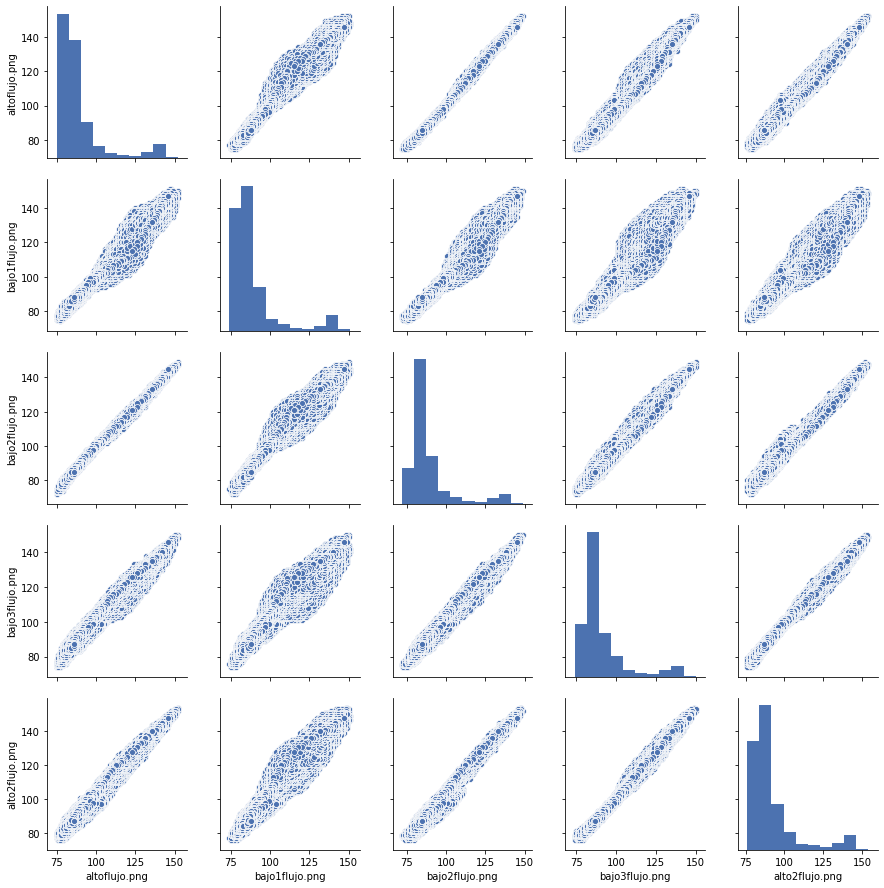

In [9]:
# SUPER SLOW ! 
# Do not run !
sns.pairplot(intensities)

Podemos observar una gran correlación entre las intensidades de todas las imágenes.

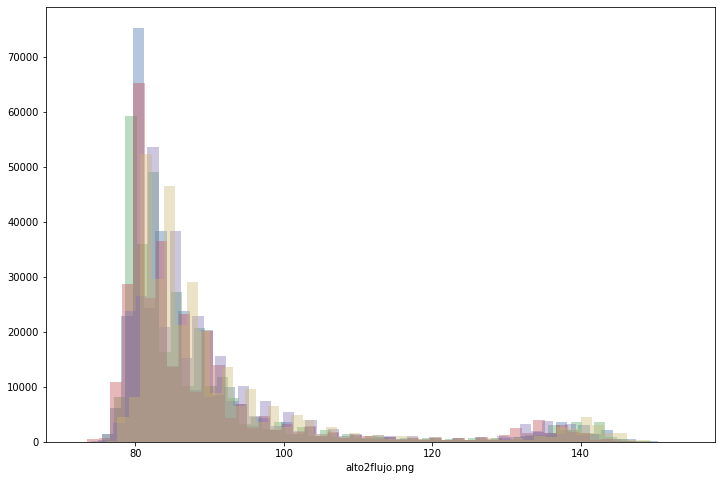

In [17]:
for i in intensities:
    sns.distplot(intensities[i],  kde=False)

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0, verbose=False).fit(intensities)

In [55]:
kmeans.cluster_centers_.shape

(2, 5)

In [56]:
kmeans.cluster_centers_[:,0]

array([ 84.96916156, 131.74852391])

In [59]:
Ks = [kmeans.cluster_centers_[:,i].mean() for i in range(kmeans.cluster_centers_.shape[1])]
Ks

[108.35884273321545,
 108.20557516047501,
 107.0071272440723,
 108.72792777565184,
 110.86496622543946]

In [60]:
K = np.floor(kmeans.cluster_centers_.mean())
K

108.0

In [24]:
centers = np.floor(kmeans.cluster_centers_)

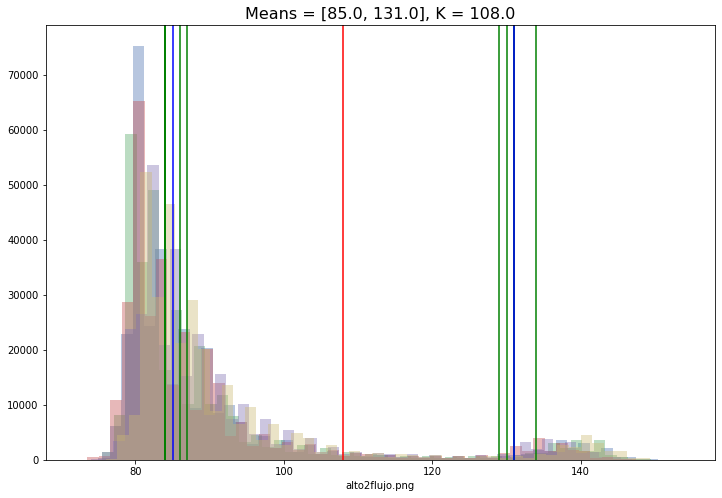

In [31]:
for i in intensities:
    sns.distplot(intensities[i],  kde=False)
plt.axvline(K, color='r')
lmap(lambda x: plt.axvline(x, color='g'), centers.flatten())
lmap(lambda x: plt.axvline(x, color='b'), lmap(np.mean, centers))
_ = plt.title(f"Means = {lmap(np.mean, centers)}, K = {K}", size=16)

Las líneas verdes respresentan las respectivas medias los cúmulos de intensidades de cada imagen. Las líneas azules representan las medias globales a través de las imágenes. La línea roja en medio de ambas es nuestro umbral.

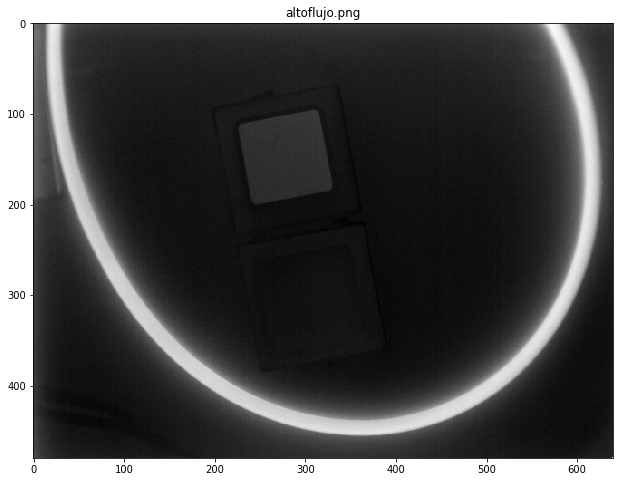

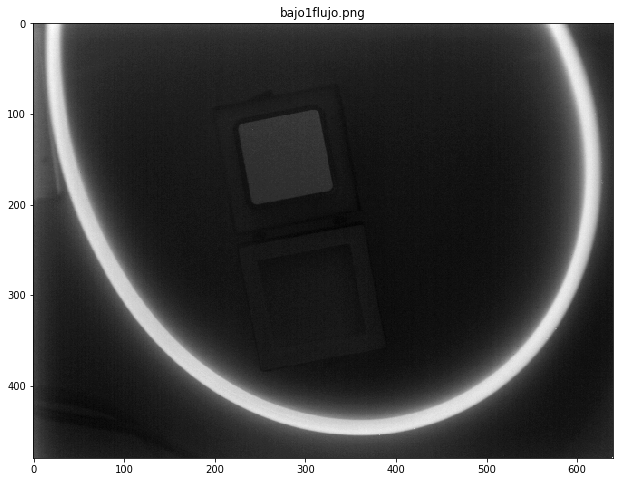

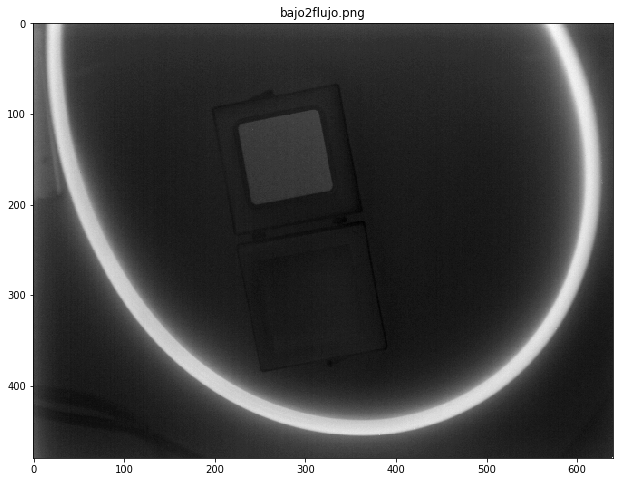

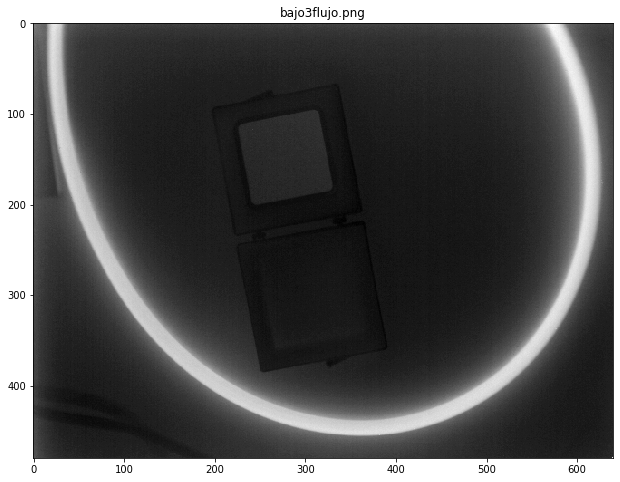

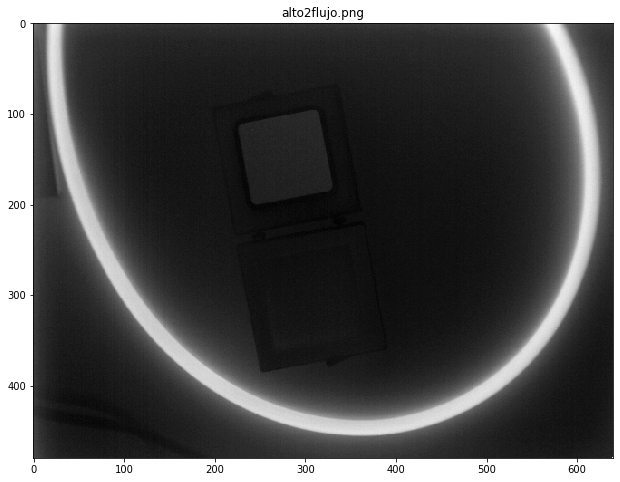

In [61]:
for nombre in mangueras.keys():
    plt.figure()
    plt.imshow(mangueras[nombre], cmap="gray")
    plt.title(nombre)

In [71]:
mangueras_segmentadas = copy.deepcopy(mangueras)

In [91]:
for i in mangueras_segmentadas.keys():
    mangueras_segmentadas[i][
        np.nonzero(mangueras_segmentadas[i] < K)
    ] = 0
    mangueras_segmentadas[i][
        np.nonzero(mangueras_segmentadas[i] >= K)
    ] = 1

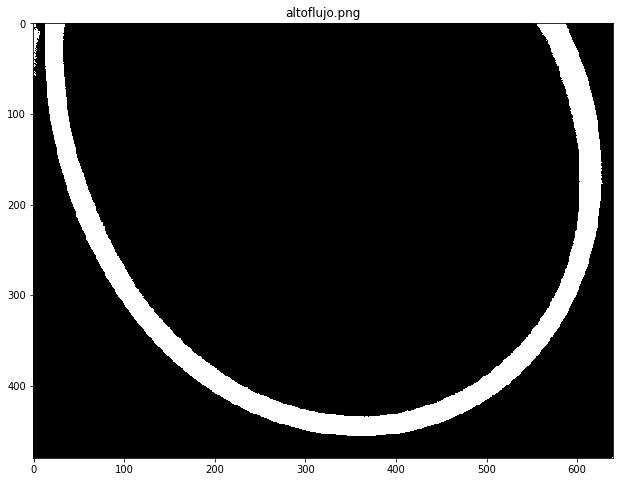

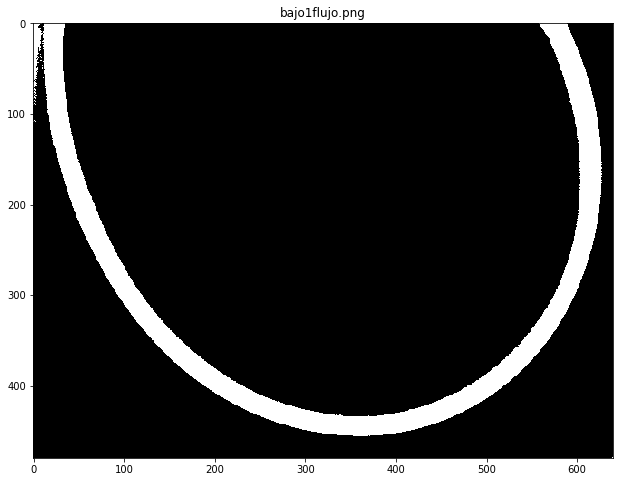

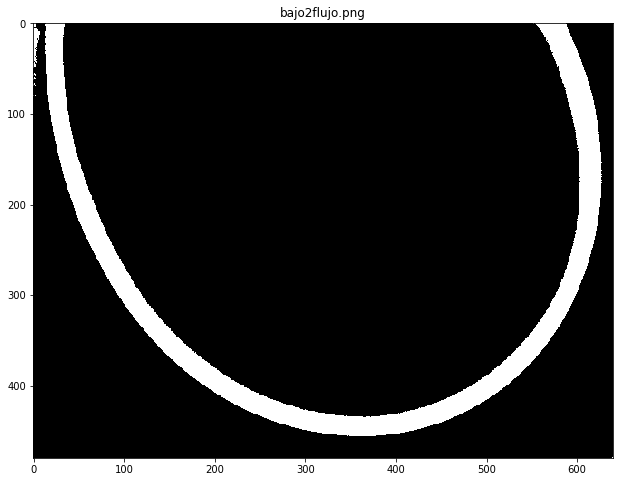

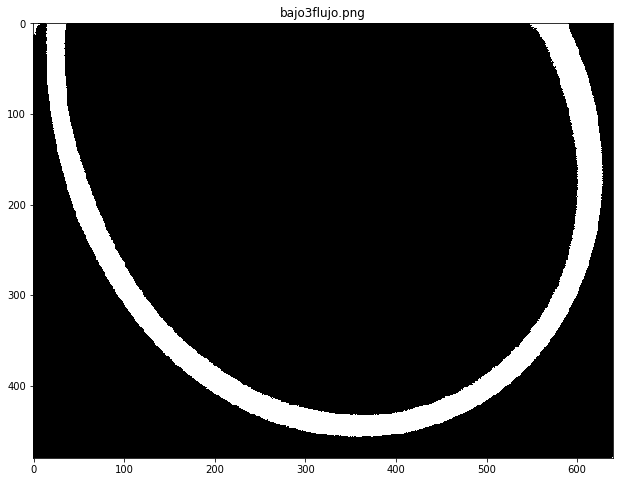

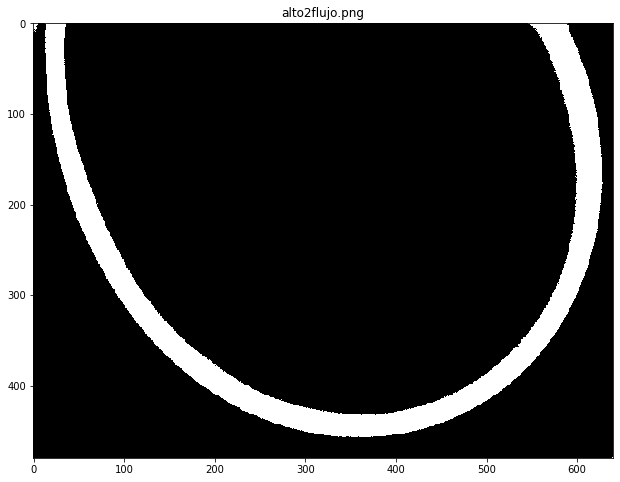

In [92]:
for nombre in mangueras_segmentadas.keys():
    plt.figure()
    plt.imshow(mangueras_segmentadas[nombre], cmap="gray")
    plt.title(nombre)

In [102]:
reg_ref_segmentadas = copy.deepcopy(mangueras)

In [ ]:
reg_ref_segmentadas = 

In [75]:
for i in reg_ref_segmentadas.keys():
    mask = np.nonzero(reg_ref_segmentadas[i] > K)
    reg_ref_segmentadas[i][mask] = 0

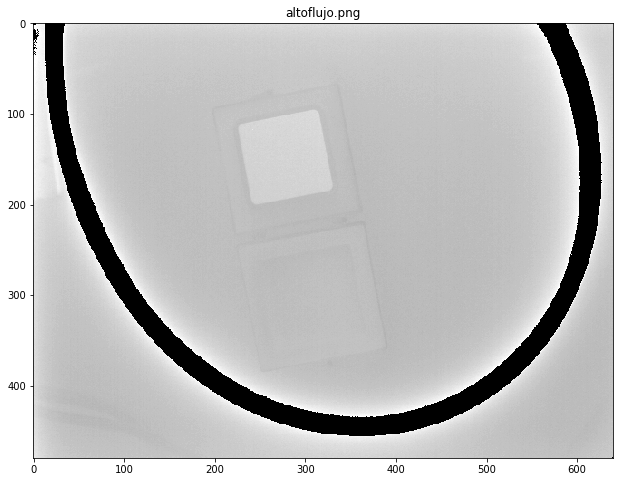

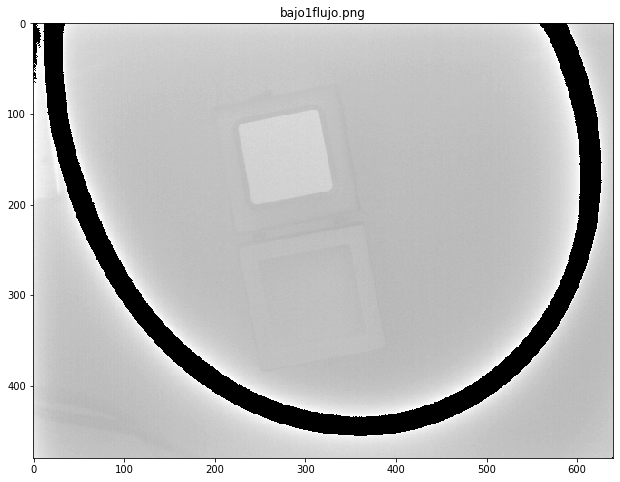

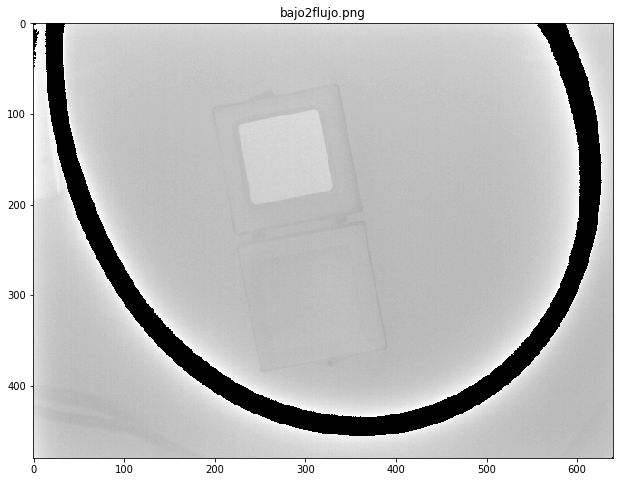

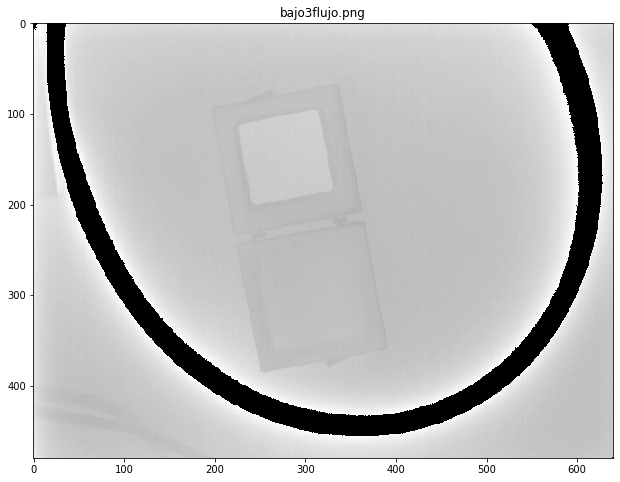

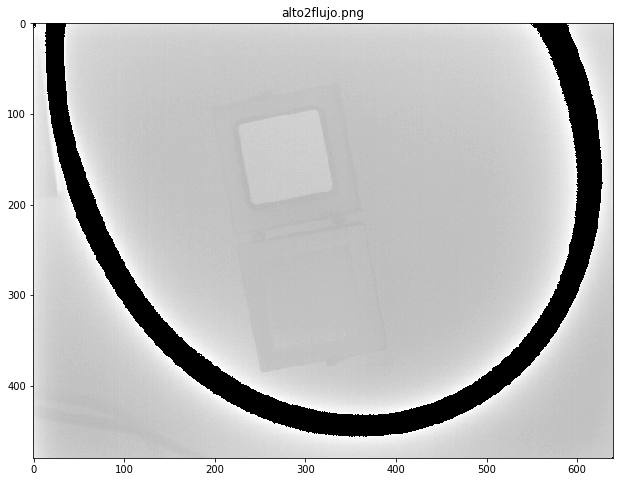

In [76]:
for nombre in reg_ref_segmentadas.keys():
    plt.figure()
    plt.imshow(reg_ref_segmentadas[nombre], cmap="gray")
    plt.title(nombre)

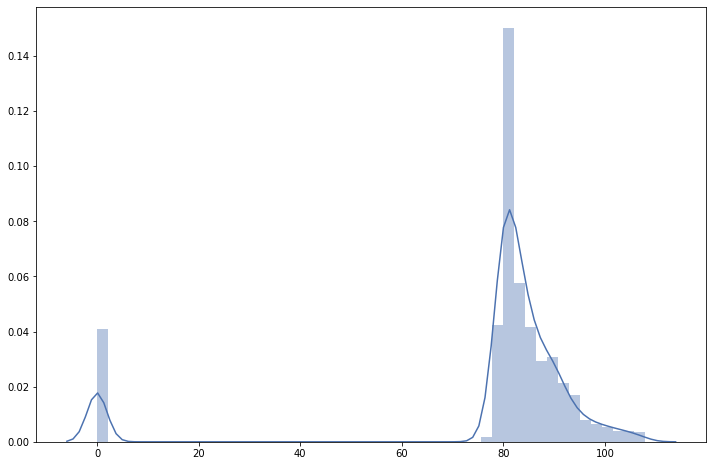

In [79]:
sns.distplot(reg_ref_segmentadas['altoflujo.png'].flatten())

In [80]:
intensities2 = pd.core.frame.DataFrame({
    key: reg_ref_segmentadas[key].flatten() for key in reg_ref_segmentadas.keys()
})

In [101]:
"""kmeans2 = KMeans(
    n_clusters=2, 
    random_state=0, 
    verbose=False
).fit(
    intensities2.
)"""

'kmeans2 = KMeans(\n    n_clusters=2, \n    random_state=0, \n    verbose=False\n).fit(\n    intensities2.\n)'

In [93]:
seg = mangueras[llaves[0]] * 

In [98]:
seg.max(), mangueras[llaves[0]].max(), mangueras_segmentadas[llaves[0]].max()

(152, 152, 1)

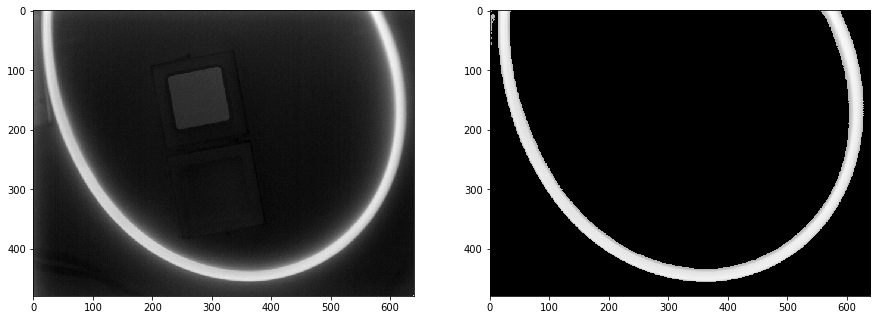

In [99]:
utils.side_by_side(mangueras[llaves[0]], seg)

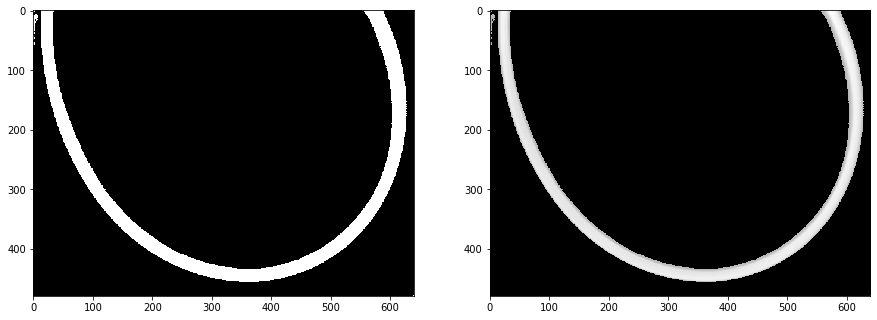

In [100]:
utils.side_by_side(mangueras_segmentadas[llaves[0]], seg)

In [108]:
mangueras_segmentadas[llaves[0]].dtype

dtype('uint8')

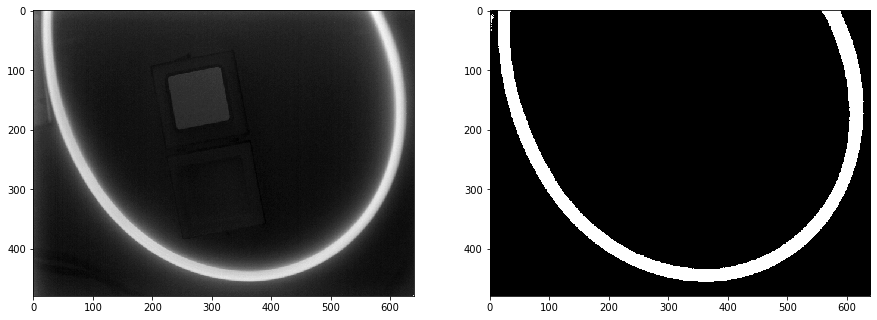

In [133]:
_tmp_img = mangueras[llaves[0]]
utils.side_by_side(_tmp_img, auto_segment(_tmp_img, groups=2))

In [117]:
_tmp_img.flatten().reshape(-1, 1)

array([[109],
       [109],
       [109],
       ...,
       [ 86],
       [ 86],
       [146]], dtype=uint8)

In [123]:
y = [[1, 2], [3, 4]]

In [125]:
print(*y)

[1, 2] [3, 4]


Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 13485328.977020722
start iteration
done sorting
end inner loop
Iteration 1, inertia 13252811.365107602
start iteration
done sorting
end inner loop
Iteration 2, inertia 13252811.365107602
center shift 0.000000e+00 within tolerance 2.233664e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 14893887.94899832
start iteration
done sorting
end inner loop
Iteration 1, inertia 13518975.76939588
start iteration
done sorting
end inner loop
Iteration 2, inertia 13280673.94659304
start iteration
done sorting
end inner loop
Iteration 3, inertia 13245014.90325684
start iteration
done sorting
end inner loop
Iteration 4, inertia 13245014.90325684
center shift 0.000000e+00 within tolerance 2.233664e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 13280673.94659304
start iteration
done sorting
end inner loop
Iteration 1, inertia 1

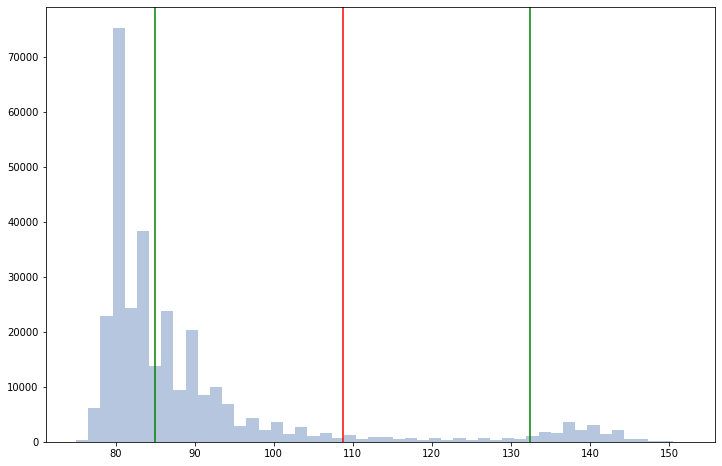

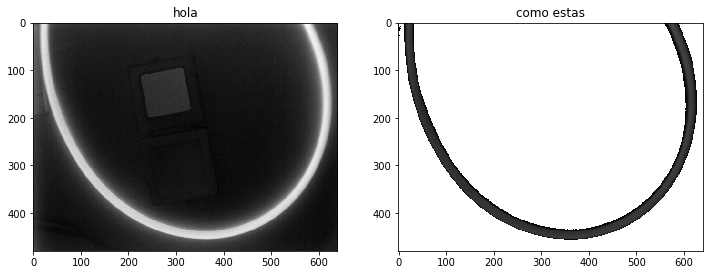

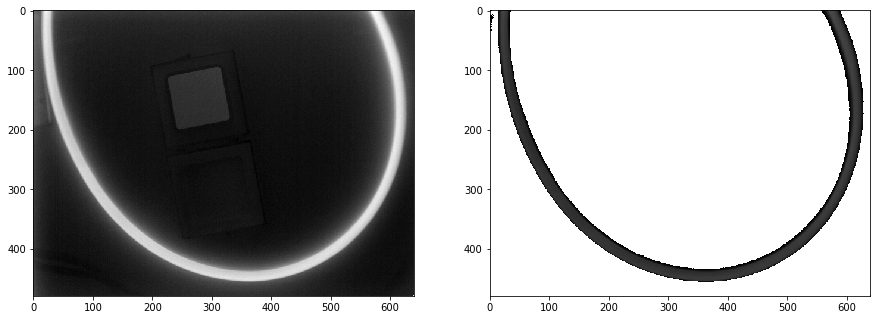

In [196]:
_tmp_img = mangueras[llaves[0]]
mask = auto_segment(_tmp_img, verbose=True, groups=2)
utils.side_by_side(_tmp_img, mask)

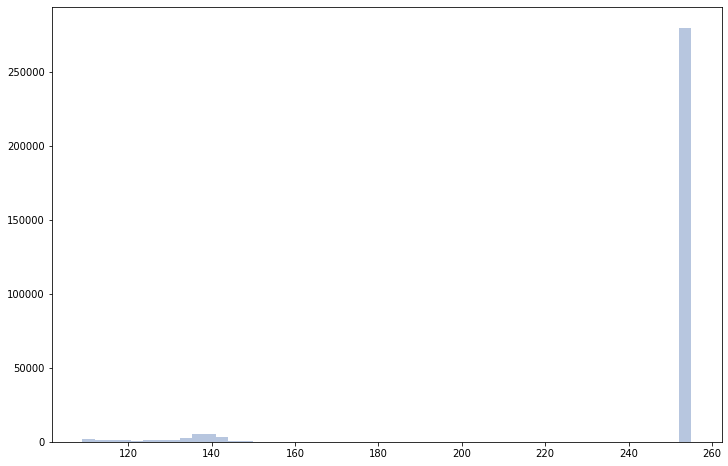

In [198]:
sns.distplot(mask.flatten(), kde=False)

In [170]:
mask[ mask == 63 ].shape

(139985,)

In [177]:
2*512*512


524288

In [181]:
x= np.linspace(0, 1)

In [182]:
x[-]

SyntaxError: invalid syntax (<ipython-input-182-ead70217b2ec>, line 1)

In [184]:
x[::-1] 

array([1.        , 0.97959184, 0.95918367, 0.93877551, 0.91836735,
       0.89795918, 0.87755102, 0.85714286, 0.83673469, 0.81632653,
       0.79591837, 0.7755102 , 0.75510204, 0.73469388, 0.71428571,
       0.69387755, 0.67346939, 0.65306122, 0.63265306, 0.6122449 ,
       0.59183673, 0.57142857, 0.55102041, 0.53061224, 0.51020408,
       0.48979592, 0.46938776, 0.44897959, 0.42857143, 0.40816327,
       0.3877551 , 0.36734694, 0.34693878, 0.32653061, 0.30612245,
       0.28571429, 0.26530612, 0.24489796, 0.2244898 , 0.20408163,
       0.18367347, 0.16326531, 0.14285714, 0.12244898, 0.10204082,
       0.08163265, 0.06122449, 0.04081633, 0.02040816, 0.        ])